In [1]:
# Import the needed referances
import pandas as pd
import numpy as np
import seaborn as sns
import csv as csv

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

#Shuffle the datasets
from sklearn.utils import shuffle

#Learning curve
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

#Output plots in notebook
%matplotlib inline 

addpoly = True
plot_lc =  1  # 1--display learning curve/ 0 -- don't display

In [2]:
#loading the data sets from the csv files
print('--------load train & test file------')
train_dataset = pd.read_csv("train.csv")
test_dataset = pd.read_csv("test.csv")

print('train dataset: %s, test dataset %s' %(str(train_dataset.shape), str(test_dataset.shape)) )
train_dataset.head()


--------load train & test file------
train dataset: (891, 12), test dataset (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print('Id is unique.') if train_dataset.PassengerId.nunique() == train_dataset.shape[0] else print('oops')
print('Train and test sets are distinct.') if len(np.intersect1d(train_dataset.PassengerId.values, test_dataset.PassengerId.values))== 0 else print('oops')
# print('We do not need to worry about missing values.') if train_dataset.count().min() == train_dataset.shape[0] and test_dataset.count().min() == test_dataset.shape[0] else print('oops we have nan')

datasetHasNan = False
if train_dataset.count().min() == train_dataset.shape[0] and test_dataset.count().min() == test_dataset.shape[0] :
    print('We do not need to worry about missing values.') 
else:
    datasetHasNan = True
    print('oops we have nan')

Id is unique.
Train and test sets are distinct.
oops we have nan


In [4]:
print('----train dataset column types information-------')
dtype_df = train_dataset.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

----train dataset column types information-------


,Column Type,Count
0,int64,5
1,float64,2
2,object,5


In [5]:
print('----train dataset information-------')
dtype_df

----train dataset information-------


,Count,Column Type
0,PassengerId,int64
1,Survived,int64
2,Pclass,int64
3,Name,object
4,Sex,object
5,Age,float64
6,SibSp,int64
7,Parch,int64
8,Ticket,object
9,Fare,float64


In [6]:
#Check for missing data & list them 
if datasetHasNan == True:
    nas = pd.concat([train_dataset.isnull().sum(), test_dataset.isnull().sum()], axis=1,  keys=['Train Dataset', 'Test Dataset']) 
    print('Nan in the data sets')
    print(nas[nas.sum(axis=1) > 0])

Nan in the data sets
          Train Dataset  Test Dataset
Age                 177          86.0
Fare                  0           1.0
Cabin               687         327.0
Embarked              2           0.0


In [7]:
# Class vs Survived
print(train_dataset[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


In [8]:
print(train_dataset[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [9]:
print(train_dataset[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())

      Sex  Survived
0  female  0.742038
1    male  0.188908


In [10]:
# SibSp vs Survived
#Sibling = brother, sister, stepbrother, stepsister
#Spouse = husband, wife (mistresses and fiancés were ignored)
print(train_dataset[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


In [11]:
# Parch vs Survived
#Parent = mother, father
#Child = daughter, son, stepdaughter, stepson
#Some children travelled only with a nanny, therefore parch=0 for them.
print(train_dataset[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False))

   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000


In [12]:
# Data sets cleaing, fill nan (null) where needed and delete uneeded columns
print('----Strat data cleaning ------------')

#train_dataset['IsMinor'] = 0
#train_dataset.loc[(train_dataset['Age'] < 14) & ((train_dataset['Pclass'] == 1) | (train_dataset['Pclass'] == 2) ), 'IsMinor'] = 1

#test_dataset['IsMinor'] = 0
#test_dataset.loc[(test_dataset['Age'] < 14) & ((test_dataset['Pclass'] == 1 ) | (test_dataset['Pclass'] == 2 )), 'IsMinor'] = 1

#manage Age
train_random_ages = np.random.randint(train_dataset["Age"].mean() - train_dataset["Age"].std(),
                                          train_dataset["Age"].mean() + train_dataset["Age"].std(),
                                          size = train_dataset["Age"].isnull().sum())

test_random_ages = np.random.randint(test_dataset["Age"].mean() - test_dataset["Age"].std(),
                                          test_dataset["Age"].mean() + test_dataset["Age"].std(),
                                          size = test_dataset["Age"].isnull().sum())

train_dataset["Age"][np.isnan(train_dataset["Age"])] = train_random_ages
test_dataset["Age"][np.isnan(test_dataset["Age"])] = test_random_ages
train_dataset['Age'] = train_dataset['Age'].astype(int)
test_dataset['Age']    = test_dataset['Age'].astype(int)

# Embarked 
train_dataset["Embarked"].fillna('S', inplace=True)
test_dataset["Embarked"].fillna('S', inplace=True)
train_dataset['Port'] = train_dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
test_dataset['Port'] = test_dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)
del train_dataset['Embarked']
del test_dataset['Embarked']

# Fare
test_dataset["Fare"].fillna(test_dataset["Fare"].median(), inplace=True)

----Strat data cleaning ------------


<ipython-input-12-771a51118a2b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset["Age"][np.isnan(train_dataset["Age"])] = train_random_ages
<ipython-input-12-771a51118a2b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset["Age"][np.isnan(test_dataset["Age"])] = test_random_ages


In [13]:
# Feature that tells whether a passenger had a cabin on the Titanic
train_dataset['Has_Cabin'] = train_dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test_dataset['Has_Cabin'] = test_dataset["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# engineer a new Title feature
# group them
full_dataset = [train_dataset, test_dataset]

##engineer the family size feature
for dataset in full_dataset:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
### new try 

# Create new feature IsAlone from FamilySize
for dataset in full_dataset:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
##############################

# Get titles from the names
train_dataset['Title'] = train_dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_dataset['Title'] = test_dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

for dataset in full_dataset:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
## Create new column "FamilySizeGroup" and assign "Alone", "Small" and "Big"
for dataset in full_dataset:
    dataset['FamilySizeGroup'] = 'Small'
    dataset.loc[dataset['FamilySize'] == 1, 'FamilySizeGroup'] = 'Alone'
    dataset.loc[dataset['FamilySize'] >= 5, 'FamilySizeGroup'] = 'Big'
    
## Get the average survival rate of different FamilySizes
train_dataset[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

for dataset in full_dataset:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
for dataset in full_dataset:    
    dataset.loc[ dataset['Age'] <= 14, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 14) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

for dataset in full_dataset:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [14]:
# map the new features
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
family_mapping = {"Small": 0, "Alone": 1, "Big": 2}
for dataset in full_dataset:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['FamilySizeGroup'] = dataset['FamilySizeGroup'].map(family_mapping)
    
# engineer a new  features
for dataset in full_dataset:
    dataset['IsChildandRich'] = 0
    dataset.loc[(dataset['Age'] <= 0) & (dataset['Pclass'] == 1 ),'IsChildandRich'] = 1  
    dataset.loc[(dataset['Age'] <= 0) & (dataset['Pclass'] == 2 ),'IsChildandRich'] = 1 
    
#for dataset in full_dataset:
#    dataset['Age*Class'] = dataset.Age * dataset.Pclass 


#for dataset in full_dataset:
#    dataset['Sex*Class'] = dataset.Sex * dataset.Pclass 

#for dataset in full_dataset:
#    dataset['Sex*Age'] = dataset.Sex * dataset.Age 
    
#for dataset in full_dataset:
#    dataset['Age*Class*Sex'] = (dataset.Age * dataset.Pclass) + dataset.Sex

for data in full_dataset:
    # classify Cabin by fare
    data['Cabin'] = data['Cabin'].fillna('X')
    data['Cabin'] = data['Cabin'].apply(lambda x: str(x)[0])
    data['Cabin'] = data['Cabin'].replace(['A', 'D', 'E', 'T'], 'M')
    data['Cabin'] = data['Cabin'].replace(['B', 'C'], 'H')
    data['Cabin'] = data['Cabin'].replace(['F', 'G'], 'L')
    data['Cabin'] = data['Cabin'].map({'X': 0, 'L': 1, 'M': 2, 'H': 3}).astype(int) 
    #data['Cabin'].loc[~data['Cabin'].isnull()] = 1
    #data['Cabin'].loc[data['Cabin'].isnull()] = 0

    
# Delete Name column from datasets (No need for them in the analysis)
del train_dataset['Name']
del test_dataset['Name']

del train_dataset['SibSp']
del test_dataset['SibSp']

del train_dataset['Parch']
del test_dataset['Parch']

del train_dataset['FamilySize']
del test_dataset['FamilySize']

#del train_dataset['FamilySizeGroup']
#del test_dataset['FamilySizeGroup']

del train_dataset['Cabin']
del test_dataset['Cabin']

# Delete Ticket column from datasets  (No need for them in the analysis)
del train_dataset['Ticket']
del test_dataset['Ticket']

del train_dataset['Port']
del test_dataset['Port']


# Cabin has a lot of nan values, so i will remove it
#del train_dataset['Cabin']
#del test_dataset['Cabin']

##title_dummies_titanic  = pd.get_dummies(train_dataset['Title'])
##train_dataset = train_dataset.join(title_dummies_titanic)

##
##title_dummies_titanic  = pd.get_dummies(test_dataset['Title'])
##test_dataset = test_dataset.join(title_dummies_titanic)
##
### Drop
##train_dataset.drop(['Title'], axis=1,inplace=True)
##test_dataset.drop(['Title'], axis=1,inplace=True)


print('----Finish data cleaning ------------')

----Finish data cleaning ------------


In [15]:
print('train dataset: %s, test dataset %s' %(str(train_dataset.shape), str(test_dataset.shape)) )
train_dataset.head(10)

train dataset: (891, 11), test dataset (418, 10)


,PassengerId,Survived,Pclass,Sex,Age,Fare,Has_Cabin,IsAlone,Title,FamilySizeGroup,IsChildandRich
0,1,0,3,0,1,0,0,0,1,0,0
1,2,1,1,1,2,3,1,0,3,0,0
2,3,1,3,1,1,1,0,1,2,1,0
3,4,1,1,1,2,3,1,0,3,0,0
4,5,0,3,0,2,1,0,1,1,1,0
5,6,0,3,0,1,1,0,1,1,1,0
6,7,0,1,0,3,3,1,1,1,1,0
7,8,0,3,0,0,2,0,0,4,2,0
8,9,1,3,1,1,1,0,0,3,0,0
9,10,1,2,1,0,2,0,0,3,0,1


In [16]:
del train_dataset['PassengerId']

#X_train = train_dataset.drop("Survived",axis=1).as_matrix()
#Y_train = train_dataset["Survived"].as_matrix()
#X_test  = test_dataset.drop("PassengerId",axis=1).copy().as_matrix()

X_train = train_dataset.drop("Survived",axis=1)
Y_train = train_dataset["Survived"]
X_test  = test_dataset.drop("PassengerId",axis=1).copy()

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(891, 9)
(891,)
(418, 9)


In [18]:
### try polynomials:
from sklearn.preprocessing import MinMaxScaler,PolynomialFeatures

if addpoly:
    all_data = pd.concat((X_train,
                          X_test), ignore_index=True)

    scaler = MinMaxScaler()
    scaler.fit(all_data)
    all_data=scaler.transform(all_data)
    poly = PolynomialFeatures(2)
    all_data=poly.fit_transform(all_data)

    X_train = all_data[:train_dataset.shape[0]]
    X_test = all_data[train_dataset.shape[0]:]
    ##
    print(X_train.shape)
    print(Y_train.shape)
    print(X_test.shape)

(891, 55)
(891,)
(418, 55)


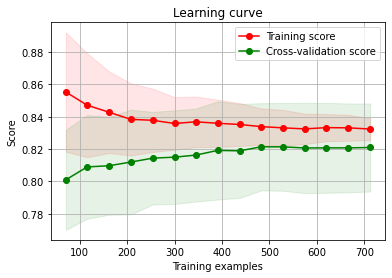

In [23]:
# Learning curve
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
logreg_model = LogisticRegression()
def Learning_curve_model(X, Y, model, cv, train_sizes):

    plt.figure()
    plt.title("Learning curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")


    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, cv=cv, n_jobs=4, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
                     
    plt.legend(loc="best")
    return plt

#learn curve
if plot_lc==1:
    train_size=np.linspace(.1, 1.0, 15)
    Learning_curve_model(X_train,Y_train , logreg_model, cv, train_size)

In [27]:
# Logistic Regression
logreg = LogisticRegression() #(C=0.1, penalty='l1', tol=1e-6)
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

result_train = logreg.score(X_train, Y_train)
result_val = cross_val_score(logreg,X_train, Y_train, cv=5).mean()
print('training score = %s , while validation score = %s' %(result_train , result_val))

training score = 0.8305274971941639 , while validation score = 0.8192768815516915


In [28]:
### Support Vector Machines
##
###from sklearn import svm, grid_search
###from sklearn.grid_search import GridSearchCV
###Cs = [0.001, 0.01, 0.1, 1, 10]
###gammas = [0.001, 0.01, 0.1, 1]
###param_grid = {'C': Cs, 'gamma' : gammas}
###grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5)
###grid_search.fit(X_train, Y_train)
###print(grid_search.best_params_)
##
svc = SVC(C = 0.1, gamma=0.1)
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)

result_train = svc.score(X_train, Y_train)
result_val = cross_val_score(svc,X_train, Y_train, cv=5).mean()
print('taring score = %s , while validation score = %s' %(result_train , result_val))

taring score = 0.8237934904601572 , while validation score = 0.8226539451384094


In [30]:
# Random Forests

random_forest = RandomForestClassifier(criterion='gini', 
                             n_estimators=1000,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)

seed= 42
random_forest =RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=5, min_samples_split=2,
                           min_samples_leaf=1, max_features='auto',    bootstrap=False, oob_score=False, 
                           n_jobs=1, random_state=seed,verbose=0)

random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)

result_train = random_forest.score(X_train, Y_train)
result_val = cross_val_score(random_forest,X_train, Y_train, cv=5).mean()

print('taring score = %s , while validation score = %s' %(result_train , result_val))

taring score = 0.8417508417508418 , while validation score = 0.8226727763480008


In [31]:
submission = pd.DataFrame({
        "PassengerId": test_dataset["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)
print('Exported')

Exported
